In [1]:
# import libraries 
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
import numpy as np
from collections import Counter
from scipy.stats import uniform
import warnings
from sklearn.cluster import KMeans, AgglomerativeClustering
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
warnings.filterwarnings('ignore')

In [2]:
posts_df = pd.read_pickle('../data/interum/text_target.pkl')

In [3]:
posts_df.head(2)

,id,body,tags,text,target,cleaned_text,tokens
0,111102,<p>How would you explain JavaScript closures t...,javascript|scope|closures,\n\nHow would you explain JavaScript closures ...,javascript,would explain closure someone knowledge concep...,"[would, explain, closure, someone, knowledge, ..."
1,1642028,<p>After reading <a href= http://groups.google...,c++|c|operators|code-formatting|standards-comp...,\n\nAfter reading Hidden Features and Dark Cor...,c++,read hidden feature dark corner c stl comp lan...,"[read, hidden, feature, dark, corner, c, stl, ..."


In [4]:
# convert into features and target 
feature = posts_df['cleaned_text']
label = posts_df['target']

In [5]:
tfid_vect = TfidfVectorizer()
X = tfid_vect.fit_transform(feature)

In [10]:
# scale 
Tsv = TruncatedSVD()

In [11]:
X_scaled = Tsv.fit_transform(X)

In [12]:
Tsv.fit(X).explained_variance_ratio_

array([0.0026225 , 0.00623924])

In [28]:
x = X_scaled[:,0]
y = X_scaled[:,1]
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
label.unique()

array(['javascript', 'c++', 'python', 'java', 'c#'], dtype=object)

In [32]:
cdict = {'javascript':'red','c++':'blue','python':'green','java':'orange', 'c#':'yellow'}

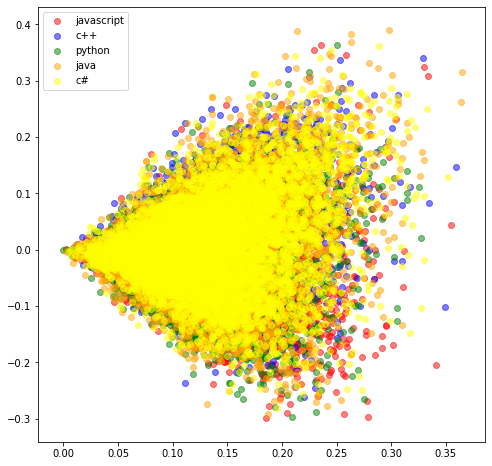

In [40]:
fig, ax = plt.subplots(figsize = (8,8))
for g in label.unique():
    ix = np.where(label == g)
    ax.scatter(x[ix],y[ix],c=cdict[g],label = g, alpha = 0.5)
ax.legend()
plt.show()

In [46]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [52]:
with open('kmeans.pkl','wb') as f:
    pickle.dump(kmeans,f)

In [53]:
with open('kmeans.pkl','rb') as f:
    kmeans = pickle.load(f)

In [55]:
with open('pred_kmean.pkl','wb') as f:
    pickle.dump(pred,f)

In [56]:
with open('pred_kmean.pkl','rb') as f:
    pred = pickle.load(f)

In [50]:
pred = kmeans.predict(X)

In [57]:
silhouette_score(X,pred)

0.003577455812403246

In [58]:
pred[:5]

array([4, 2, 4, 4, 3], dtype=int32)

In [8]:
# split into train test
train_X, test_X, train_y, test_y = train_test_split(
    feature, label, stratify = label, test_size = 0.2, random_state = 42)

## tfidVector Feature

In [9]:
# try tfidVector 
tfid_vect = TfidfVectorizer()
tfid_vect.fit_transform(train_X)

<24241x57072 sparse matrix of type '<class 'numpy.float64'>'
	with 949219 stored elements in Compressed Sparse Row format>

In [10]:
# transform the training and test sets 
x_train_tfidf = tfid_vect.transform(train_X)
x_test_tfidf =tfid_vect.transform(test_X)

In [59]:
# initlaize all models
rf = RandomForestClassifier(random_state=42)
lg = LogisticRegression(random_state=42)
svc = SVC(random_state=42)
nb = MultinomialNB()
# xg = XGBClassifier(random_state = 42)
ada = AdaBoostClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)

In [66]:
# try vanilla models 
for base_clf in (rf,lg,svc,nb,ada,gb):
        clf = OneVsRestClassifier(base_clf)
        cv_results = cross_validate(clf,x_train_tfidf,train_y, cv = 3,n_jobs=-1,return_train_score= True)
        print(base_clf)
        print('test:', cv_results['test_score'])
        print('train:', cv_results['train_score'])


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
test: [0.74285361 0.74569979 0.74811239]
train: [0.9977104  0.99740099 0.99733944]
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
test: [0.80076723 0.79940601 0.79848991]
train: [0.88768564 0.88935644 0.89419626]
SVC(C=1.0, cache_si

## we will focus on:

* MultinomialNB
* RandomForest
* LogisticRegression

## hyperparameter for logistic regression 

In [202]:
pipeline = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf',lg ),
])
# Create regularization hyperparameter distribution using uniform distribution
C =uniform(loc=0, scale=4)
max_df = np.linspace(0.3,0.75,num = 10)
min_df = np.arange(1,16,2)
max_features = np.arange(5000,10000,500)
parameters = {
        'vect__ngram_range':((1,1),(1,2)),
        'vect__max_df': max_df,
        'vect__min_df':min_df,
        'vect__max_features':max_features,
        'clf': (lg,),
        'clf__penalty': ('l1','l2'),
        'clf__C': C}
clf_lg = RandomizedSearchCV(pipeline, parameters,random_state = 42, n_iter=100, cv = 3, n_jobs=14)

In [65]:
clf_lg.fit(train_X,train_y)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('vect',
                                              TfidfVectorizer(analyzer='word',
                                                              binary=False,
                                                              decode_error='strict',
                                                              dtype=<class 'numpy.float64'>,
                                                              encoding='utf-8',
                                                              input='content',
                                                              lowercase=True,
                                                              max_df=1.0,
                                                              max_features=None,
                                                              min_df=1,
                                        

In [66]:
clf_lg.best_params_

{'clf': LogisticRegression(C=2.343102325093853, class_weight=None, dual=False,
                    fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                    max_iter=100, multi_class='warn', n_jobs=None, penalty='l1',
                    random_state=42, solver='warn', tol=0.0001, verbose=0,
                    warm_start=False),
 'clf__C': 2.343102325093853,
 'clf__penalty': 'l1',
 'vect__max_df': 0.45,
 'vect__max_features': 8500,
 'vect__min_df': 7,
 'vect__ngram_range': (1, 2)}

In [67]:
clf_lg.best_score_

0.8127965017944804

In [249]:
# finer search
pipeline = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', lg),
])
parameters = {
        'vect__ngram_range':((1,2),),
        'vect__max_df': (0.4,0.5),
        'vect__min_df':(6,8),
        'vect__max_features':(8000,9000),
        'clf': (lg,),
        'clf__penalty': ('l1','l2'),
        'clf__C': (2,3,4)}
grid_search_lg = GridSearchCV(pipeline, parameters, cv = 3, return_train_score= True,n_jobs=14)

In [250]:
grid_search_lg.fit(train_X,train_y)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                          

In [76]:
grid_search_lg.best_params_

{'clf': LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='warn', n_jobs=None, penalty='l1',
                    random_state=42, solver='warn', tol=0.0001, verbose=0,
                    warm_start=False),
 'clf__C': 2,
 'clf__penalty': 'l1',
 'vect__max_df': 0.5,
 'vect__max_features': 9000,
 'vect__min_df': 6,
 'vect__ngram_range': (1, 2)}

In [251]:
grid_search_lg.score(train_X,train_y)

0.8929912132337775

In [252]:
grid_search_lg.score(test_X,test_y)

0.8201616894901831

In [117]:
classes = grid_search_lg.classes_

In [109]:
coefs = grid_search_lg.best_estimator_['clf'].coef_

In [118]:
coefs.shape

(5, 9000)

In [114]:
featurenames = grid_search_lg.best_estimator_['vect'].get_feature_names()

In [123]:
coef_dict={}
for i, cls in enumerate(classes):
    coef_dict[cls]=[]
    for c, f in zip(coefs[i],featurenames):
        if c:
            coef_dict[cls].append((f,c))

In [128]:
sorted(coef_dict['c#'],key=lambda x: x[1],reverse = True)[:10]

[('writeline', 34.35443542592411),
 ('net', 14.409952259671503),
 ('msdn', 13.406405098449603),
 ('ienumerable', 12.597638498674106),
 ('script jquery', 12.258235070200952),
 ('streamreader', 12.207305885657282),
 ('linq', 12.060271676062444),
 ('window form', 11.696983129235713),
 ('winforms', 11.34889725246229),
 ('entity framework', 11.139816376850316)]

In [129]:
sorted(coef_dict['c#'],key=lambda x: x[1])[:10]

[('println', -29.522974297537914),
 ('django', -17.091895906609306),
 ('pythonic', -16.322255328863903),
 ('spring', -16.15729795551023),
 ('sun', -15.73658807129685),
 ('def', -15.077989494940644),
 ('jquery', -15.06177845407277),
 ('std', -13.810242160767265),
 ('gcc', -13.09393849381091),
 ('jvm', -12.65241004520841)]

## hyperparmater for RandomForest 

In [135]:
pipeline = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf',rf),
])
# Create regularization hyperparameter distribution using uniform distribution
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=200, stop=800, num=10)]
# Number of features to consider at every split
mf = ['auto', 'sqrt']
# Minimum number of samples required to split a node
min_samples_split = [10, 20, 30]
max_df = np.linspace(0.3,0.75,num = 10)
min_df = np.arange(1,16,2)
max_features = np.arange(5000,10000,500)
parameters = {
        'vect__ngram_range':((1,1),(1,2)),
        'vect__max_df': max_df,
        'vect__min_df':min_df,
        'vect__max_features':max_features,
        'clf': (rf,),
        'clf__n_estimators': n_estimators,
        'clf__max_features': mf,
        'clf__min_samples_split': min_samples_split}
clf_rf = RandomizedSearchCV(pipeline, parameters,random_state = 42, n_iter=100, cv = 3, n_jobs=14)

In [136]:
clf_rf.fit(train_X,train_y)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('vect',
                                              TfidfVectorizer(analyzer='word',
                                                              binary=False,
                                                              decode_error='strict',
                                                              dtype=<class 'numpy.float64'>,
                                                              encoding='utf-8',
                                                              input='content',
                                                              lowercase=True,
                                                              max_df=1.0,
                                                              max_features=None,
                                                              min_df=1,
                                        

In [138]:
clf_rf.score(train_X,train_y)

0.9900169134936677

In [139]:
clf_rf.score(test_X,test_y)

0.7922785018973767

In [140]:
clf_rf.best_params_

{'vect__ngram_range': (1, 1),
 'vect__min_df': 3,
 'vect__max_features': 9000,
 'vect__max_df': 0.6000000000000001,
 'clf__n_estimators': 533,
 'clf__min_samples_split': 30,
 'clf__max_features': 'auto',
 'clf': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                        max_depth=None, max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=30,
                        min_weight_fraction_leaf=0.0, n_estimators=533,
                        n_jobs=None, oob_score=False, random_state=42, verbose=0,
                        warm_start=False)}

In [228]:
# finer search
pipeline = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', rf),
])
parameters = {
        'vect__ngram_range':((1,1),),
        'vect__max_df': (0.55,0.65),
        'vect__min_df':(2,4),
        'vect__max_features':(8500,9500),
        'clf': (rf,),
        'clf__n_estimators': (500,600),
        'clf__min_samples_split': (25,35),
        'clf__max_features':('auto',)}
grid_search_rf = GridSearchCV(pipeline, parameters, cv = 3, return_train_score= True,n_jobs=14)

In [229]:
grid_search_rf.fit(train_X,train_y)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                          

In [230]:
grid_search_rf.score(train_X,train_y)

0.9871704962666557

In [231]:
grid_search_rf.score(test_X,test_y)

0.7922785018973767

In [233]:
featurenames_rf = grid_search_rf.best_estimator_['vect'].get_feature_names()

In [234]:
coefs_rf = grid_search_rf.best_estimator_['clf'].feature_importances_
coef_f_rf =[]
for c, f in zip(coefs_rf,featurenames_rf):
        if c:
            coef_f_rf.append((f,c))

In [235]:
sorted(coef_f_rf, key=lambda x: x[1], reverse = True)[:20]

[('jquery', 0.023405485148573425),
 ('var', 0.01950092964664314),
 ('function', 0.01671471717287409),
 ('std', 0.01641337512849392),
 ('net', 0.014702909481093665),
 ('def', 0.011136974370211484),
 ('public', 0.009981130643713813),
 ('browser', 0.009317913178577403),
 ('int', 0.00904948049191193),
 ('py', 0.008984148347329376),
 ('import', 0.008917878602245292),
 ('print', 0.007919087357927733),
 ('django', 0.007618115393399925),
 ('eclipse', 0.00761629081892026),
 ('html', 0.007360976468701237),
 ('page', 0.007088435804961556),
 ('println', 0.006406942238057315),
 ('div', 0.006234086421391037),
 ('class', 0.006119492042839767),
 ('new', 0.0058004493298996285)]

## multinominalNB 

In [212]:
# Create regularization hyperparameter distribution using uniform distribution
alpha =uniform(loc=0, scale=5)

# Create hyperparameter options
hyperparameters = dict(alpha = alpha)

pipeline = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf',nb),
])
max_df = np.linspace(0.3,0.75,num = 10)
min_df = np.arange(1,16,2)
max_features = np.arange(5000,10000,500)
parameters = {
        'vect__ngram_range':((1,1),(1,2)),
        'vect__max_df': max_df,
        'vect__min_df':min_df,
        'vect__max_features':max_features,
        'clf': (nb,),
        'clf__alpha':alpha
            }
clf_nb = RandomizedSearchCV(pipeline, parameters,random_state = 42, n_iter=100, cv = 3, n_jobs=14)

In [157]:
clf_nb.fit(train_X,train_y)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('vect',
                                              TfidfVectorizer(analyzer='word',
                                                              binary=False,
                                                              decode_error='strict',
                                                              dtype=<class 'numpy.float64'>,
                                                              encoding='utf-8',
                                                              input='content',
                                                              lowercase=True,
                                                              max_df=1.0,
                                                              max_features=None,
                                                              min_df=1,
                                        

In [178]:
coefs = clf_nb.best_estimator_['clf'].feature_log_prob_

In [167]:
featurenames = clf_nb.best_estimator_['vect'].get_feature_names()

In [169]:
classes = clf_nb.classes_

In [179]:
coef_dict_nb={}
for i, cls in enumerate(classes):
    coef_dict_nb[cls]=[]
    for c, f in zip(coefs[i],featurenames):
        if c:
            coef_dict_nb[cls].append((f,c))

In [193]:
sorted(coef_dict_nb['python'], key = lambda x: x[1], reverse = True)[:10]

[('list', -5.176939563872745),
 ('file', -5.226266278864943),
 ('use', -5.241086563635494),
 ('print', -5.3348599109029715),
 ('py', -5.419126184945497),
 ('like', -5.454631833569824),
 ('way', -5.467000383963656),
 ('self', -5.524795070266238),
 ('import', -5.55602942455358),
 ('get', -5.584474875270401)]

In [182]:
sorted(coef_dict_nb['c#'], key = lambda x: x[1])[:10]

[('abstractautowirecapablebeanfactory', -11.832941267956661),
 ('accesscontroller', -11.832941267956661),
 ('accesscontroller doprivileged', -11.832941267956661),
 ('actionbar', -11.832941267956661),
 ('activitythread', -11.832941267956661),
 ('actor', -11.832941267956661),
 ('add subplot', -11.832941267956661),
 ('addclass', -11.832941267956661),
 ('adt', -11.832941267956661),
 ('alert hello', -11.832941267956661)]

In [194]:
clf_nb.best_params_

{'clf': MultinomialNB(alpha=0.21801885877216876, class_prior=None, fit_prior=True),
 'clf__alpha': 0.21801885877216876,
 'vect__max_df': 0.5,
 'vect__max_features': 7500,
 'vect__min_df': 5,
 'vect__ngram_range': (1, 2)}

In [195]:
clf_nb.score(train_X,train_y)

0.8566065756363186

In [196]:
clf_nb.score(test_X,test_y)

0.7983831050981686

In [214]:
# finer search
pipeline = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf',nb),
])
parameters = {
        'vect__ngram_range':((1,2),),
        'vect__max_df': (0.45,0.55),
        'vect__min_df':(4,6),
        'vect__max_features':(7000,8000),
        'clf': (nb,),
        'clf__alpha': (0.2,0.3)}
grid_search_nb = GridSearchCV(pipeline, parameters, cv = 3, return_train_score= True,n_jobs=14)

In [216]:
grid_search_nb.fit(train_X,train_y)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                          

In [217]:
grid_search_nb.best_estimator_

Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.55, max_features=8000,
                                 min_df=6, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=0.2, class_prior=None, fit_prior=True))],
         verbose=False)

In [218]:
grid_search_nb.score(train_X,train_y)

0.8596180025576503

In [219]:
grid_search_nb.score(test_X,test_y)

0.799208051476654

In [220]:
coefs_nb = grid_search_nb.best_estimator_['clf'].feature_log_prob_

In [221]:
featurenames_nb = grid_search_nb.best_estimator_['vect'].get_feature_names()

In [222]:
classes = grid_search_nb.classes_

In [223]:
coef_dict_nb={}
for i, cls in enumerate(classes):
    coef_dict_nb[cls]=[]
    for c, f in zip(coefs_nb[i],featurenames_nb):
        if c:
            coef_dict_nb[cls].append((f,c))

In [227]:
sorted(coef_dict_nb['javascript'], key = lambda x: x[1], reverse = True)[:10]

[('function', -4.762648248036039),
 ('jquery', -5.0968846825146406),
 ('var', -5.12715526216715),
 ('use', -5.2164926284390285),
 ('div', -5.386255724526969),
 ('page', -5.453791435581551),
 ('html', -5.51520933477607),
 ('like', -5.527707844186999),
 ('script', -5.576720234298591),
 ('element', -5.663775381819082)]

In [226]:
sorted(coef_dict_nb['javascript'], key = lambda x: x[1])[:10]

[('accesscontroller', -11.890707962913076),
 ('accesscontroller doprivileged', -11.890707962913076),
 ('activitythread', -11.890707962913076),
 ('actor', -11.890707962913076),
 ('add int', -11.890707962913076),
 ('add reference', -11.890707962913076),
 ('add subplot', -11.890707962913076),
 ('administrator', -11.890707962913076),
 ('adt', -11.890707962913076),
 ('aliasing', -11.890707962913076)]

### combine results and do a majority vote 

In [254]:
pred_lg = grid_search_lg.predict(test_X)
pred_rf = grid_search_rf.predict(test_X)
pred_nb = grid_search_nb.predict(test_X)

In [270]:
votes = Counter([pred_lg[122],pred_rf[122], pred_nb[122]])

In [272]:
for i,v in votes.items():
    if votes[i]==max(votes.values()):
        print(i)

java


In [273]:
import numpy as np

In [ ]:
np.random.random

In [280]:
combined = []
predicted = zip(pred_lg,pred_rf,pred_nb)
for p in predicted:
    votes = Counter(p)
    most = max(votes.values())
    if most >1:
        combined.append(list(votes.keys())[list(votes.values()).index(most)])
    else:
        combined.append(np.random.choice(list(votes.keys()),1)[0])
    
    

In [287]:
accuracy_score(test_y,combined)

0.8244514106583072

In [289]:
confusion_matrix(test_y, combined)

array([[1140,   29,  126,   73,   29],
       [  48,  602,   78,   25,   23],
       [ 102,   24, 1240,   66,   62],
       [  53,    8,   56, 1227,   45],
       [  48,   20,   96,   53,  788]])

In [290]:
classes

array(['c#', 'c++', 'java', 'javascript', 'python'], dtype='<U10')

In [295]:
grid_search_lg.best_estimator_

Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.5, max_features=9000,
                                 min_df=6, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 LogisticRegression(C=2, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,

In [299]:
with open('gs_lg','wb') as f:
    pickle.dump(grid_search_lg,f)

In [300]:
with open('gs_lg','rb') as f:
    t_lg = pickle.load(f)

In [305]:
t_lg.predict(test_X)

array(['c#', 'c++', 'javascript', ..., 'c++', 'c#', 'javascript'],
      dtype=object)

In [302]:
with open('gs_rf','wb') as f:
    pickle.dump(grid_search_rf, f)

In [303]:
with open('gs_rf','rb') as f:
    t_rf = pickle.load(f)

In [304]:
t_rf.predict(test_X)

array(['c#', 'c++', 'javascript', ..., 'c#', 'c#', 'javascript'],
      dtype=object)

In [307]:
with open('gs_nb','wb') as f:
    pickle.dump(grid_search_nb,f)

In [309]:
with open('gs_nb','rb') as f:
    t_nb = pickle.load(f)

In [310]:
t_nb.predict(test_X)

array(['c#', 'c++', 'javascript', ..., 'c++', 'c#', 'javascript'],
      dtype='<U10')

In [11]:
from sklearn.decomposition import PCA
kmeans = KMeans(n_clusters=5).fit(x_train_tfidf)

KeyboardInterrupt: 

In [10]:
kmeans = KMeans(n_clusters=5)

In [ ]:
kmeans.fit(x_train_tfidf)

In [3]:
def coef_features(modelname, lg = True):
    labels = modelname.classes_  # label 
    if lg:
        coefs = modelname.best_estimator_['clf'].coef_
    else:
        coefs = modelname.best_estimator_['clf'].feature_log_prob_
    featurenames = modelname.best_estimator_['vect'].get_feature_names()
    coef_dict={}
    for i, l in enumerate(labels):
        coef_dict[l]=[]
        for c, f in zip(coefs[i],featurenames):
            if c:
                coef_dict[l].append((f,c))
    return coef_dict   

import pickle
with open('gs_nb','rb') as f:
    t_nb = pickle.load(f)
with open('gs_lg','rb') as f:
    t_lg = pickle.load(f)

lg_coef_f = coef_features(t_lg)
nb_coef_f = coef_features(t_nb)

def top_10_feature(coef_dict):
    top_10 = {}
    for l in coef_dict.keys():
        top_10[l] = sorted(coef_dict[l], key = lambda x: x[1], reverse = True)[:10]
        top_10[l] = [x[0] for x in top_10[l]]
    return pd.DataFrame(top_10)

pd.concat([top_10_feature(lg_coef_f),top_10_feature(nb_coef_f)], axis = 1)

    

,c#,c++,java,javascript,python,c#,c++,java,javascript,python
0,writeline,cout,jvm,jquery,django,string,std,string,function,list
1,net,std,jdk,backbone,py,use,int,class,jquery,file
2,msdn,boost,println,console log,numpy,public,use,use,var,use
3,ienumerable,qt,spring,prototype,def,new,const,method,use,print
4,script jquery,stl,jsp,angularjs,pythonic,class,function,public,div,py
5,streamreader,cpp,system println,jsfiddle,matplotlib,get,class,file,page,like
6,linq,int main,hibernate,angular,pep,net,code,new,html,way
7,window form,header file,jar,alert,urllib,method,vector,get,like,self
8,winforms,gcc,util,browser,beautifulsoup,code,include,code,script,import
9,entity framework,pointer,jdbc,ecmascript,typeerror,list,compiler,like,element,get
